# Trends: data exploration


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
from IPython.display import display, HTML, Markdown

## Create trends df from daily information

In [2]:
trends_path = os.path.join('data','daily_trend',"*.csv")
daily_dfs_path =  glob(trends_path)
daily_dfs = [pd.read_csv(path) for path in daily_dfs_path]
daily_dfs_names = [i.split("/")[2] for i in daily_dfs_path]
daily_dfs_names = [i.split(".")[0] for i in daily_dfs_names]

trends_df = []
for name, df in zip(daily_dfs_names, daily_dfs):
    df.index = pd.to_datetime(df.date)
    trends_df.append(df[name])

final_date = "2020-07-25"
trends_df = pd.concat(trends_df,1)
trends_df = trends_df[:final_date]
trends_df = trends_df.fillna(0.0)
trends_df = trends_df / 100
word_features = list(trends_df.columns)
word_features.sort()
display(Markdown("### Google trends data"))
display(HTML(trends_df.head(5).to_html()))
display(Markdown("#### data shape = {}".format(trends_df.shape)))

### Google trends data

,religion,investment,health,committee,invest,rare,war,lifestyle,portfolio,elections,debt,judge,tourism,winsconsin,return,house,market,cash,seats,nasdaq,fine,bonds,pennsylvania,georgia,water,greed,conty,notability,illinois,oil,massachusetts,secretary,kitchen,selling,virginia,restaurant,served,leverage,revenue,earnings,william,politics,governor,car,minister,dow jones,republican,BUY AND HOLD,risk,economics,profit,metals,voter,freedom,justice,stocks,ring,food,crisis,ohio,kentucky,arts,DOW JONES,movement,district,election,hedge,money,gains,forex,consume,votes,markets,present,growth,chance,financial,unemployment,texas,council,crash,labor,color,democratic,environment,holiday,president,earths,happy,nyse,law,police,government,vermount,fun,gold,home,short,party,federal,world,college,rights,fed,credit,movie,success,default,members,finance,cancer,case,travel,returns,consumption,union,stats,political,representatives,bubble,missouri,conflict,loss,train,culture,economy,office,headlines,ore,inflation,legal,garden,derivatives,gain,washington,buy,energy,opportunity,society,security,elected,dividend,housing,transaction,banking,tennessee,carolina,act,trader,york,fond,marriage,court,senate,sell,rich,ministry,stock
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-01,0.07,0.07,0.47,0.04,0.01,0.03,0.36,0.03,0.06,0.01,0.05,0.04,0.11,0.00,0.30,0.85,0.26,0.10,0.06,0.01,0.13,0.09,0.28,0.43,0.53,0.00,0.0,0.0,0.37,0.28,0.27,0.03,0.27,0.05,0.53,0.57,0.01,0.00,0.03,0.01,0.28,0.03,0.02,0.77,0.00,0.01,0.04,0.00,0.05,0.07,0.03,0.01,0.01,0.11,0.06,0.08,0.37,0.70,0.03,0.58,0.16,0.25,0.01,0.02,0.22,0.05,0.01,0.29,0.00,0.01,0.00,0.01,0.03,0.03,0.08,0.03,0.16,0.07,0.66,0.09,0.11,0.06,0.27,0.05,0.04,0.34,0.08,0.01,0.25,0.01,0.35,0.26,0.17,0.00,0.22,0.27,0.98,0.18,0.35,0.33,0.80,0.63,0.07,0.04,0.52,1.00,0.03,0.05,0.07,0.06,0.18,0.31,0.63,0.04,0.02,0.44,0.08,0.06,0.02,0.05,0.26,0.03,0.11,0.23,0.06,0.04,0.54,0.00,0.01,0.01,0.14,0.32,0.01,0.06,0.60,0.86,0.13,0.02,0.31,0.31,0.00,0.01,0.12,0.01,0.04,0.20,0.55,0.14,0.16,0.80,0.00,0.09,0.20,0.01,0.07,0.07,0.03,0.30
2004-01-02,0.05,0.10,0.71,0.03,0.01,0.05,0.41,0.02,0.02,0.02,0.05,0.03,0.10,0.01,0.25,0.95,0.27,0.09,0.06,0.03,0.11,0.05,0.32,0.48,0.55,0.01,0.0,0.0,0.53,0.26,0.27,0.10,0.21,0.05,0.61,0.44,0.01,0.01,0.08,0.01,0.32,0.03,0.03,0.77,0.02,0.03,0.03,0.00,0.06,0.04,0.03,0.02,0.02,0.05,0.06,0.10,0.30,0.52,0.03,0.63,0.15,0.25,0.02,0.04,0.32,0.03,0.02,0.31,0.02,0.01,0.00,0.01,0.03,0.03,0.07,0.02,0.31,0.09,0.77,0.11,0.11,0.09,0.25,0.05,0.04,0.28,0.11,0.01,0.18,0.02,0.52,0.30,0.26,0.00,0.15,0.29,0.99,0.14,0.33,0.47,0.94,0.81,0.10,0.04,0.66,0.95,0.04,0.06,0.06,0.11,0.19,0.26,0.59,0.02,0.02,0.54,0.04,0.10,0.01,0.03,0.24,0.04,0.12,0.21,0.08,0.03,0.69,0.01,0.01,0.02,0.14,0.29,0.01,0.04,0.80,0.76,0.17,0.02,0.33,0.43,0.00,0.01,0.14,0.01,0.03,0.18,0.49,0.17,0.11,0.91,0.01,0.14,0.33,0.03,0.09,0.08,0.03,0.35
2004-01-03,0.08,0.07,0.53,0.03,0.01,0.04,0.51,0.01,0.02,0.01,0.02,0.03,0.09,0.00,0.26,0.95,0.32,0.09,0.05,0.02,0.14,0.05,0.27,0.41,0.47,0.00,0.0,0.0,0.44,0.28,0.27,0.05,0.26,0.05,0.55,0.50,0.01,0.00,0.07,0.01,0.29,0.02,0.02,0.89,0.02,0.02,0.04,0.00,0.05,0.03,0.03,0.01,0.01,0.09,0.07,0.08,0.36,0.51,0.05,0.65,0.15,0.22,0.01,0.06,0.26,0.03,0.01,0.28,0.01,0.01,0.00,0.01,0.03,0.01,0.06,0.03,0.14,0.06,0.67,0.09,0.13,0.06,0.35,0.05,0.04,0.26,0.10,0.00,0.13,0.01,0.43,0.26,0.19,0.00,0.17,0.27,0.93,0.19,0.36,0.34,0.81,0.70,0.08,0.03,0.60,0.97,0.02,0.06,0.08,0.07,0.21,0.27,0.54,0.02,0.02,0.43,0.06,0.07,0.02,0.06,0.23,0.03,0.13,0.26,0.06,0.05,0.62,0.01,0.01,0.01,0.13,0.29,0.01,0.08,0.72,0.89,0.12,0.02,0.30,0.28,0.01,0.02,0.09,0.02,0.05,0.17,0.40,0.16,0.10,0.75,0.01,0.11,0.23,0.02,0.10,0.09,0.05,0.27
2004-01-04,0.07,0.08,0.55,0.03,0.01,0.05,0.60,0.02,0.02,0.01,0.05,0.03,0.08,0.01,0.24,0.86,0.25,0.10,0.06,0.02,0.13,0.06,0.26,0.46,0.48,0.01,0.0,0.0,0.43,0.24,0.26,0.04,0.26,0.06,0.56,0.38,0.01,0.01,0.07,0.01,0.34,0.02,0.02,0.8

#### data shape = (6051, 158)

### Word Signal

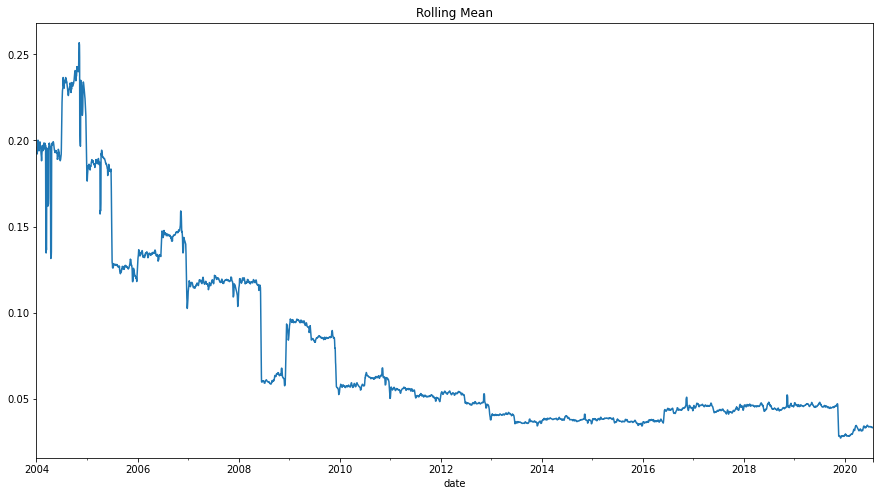

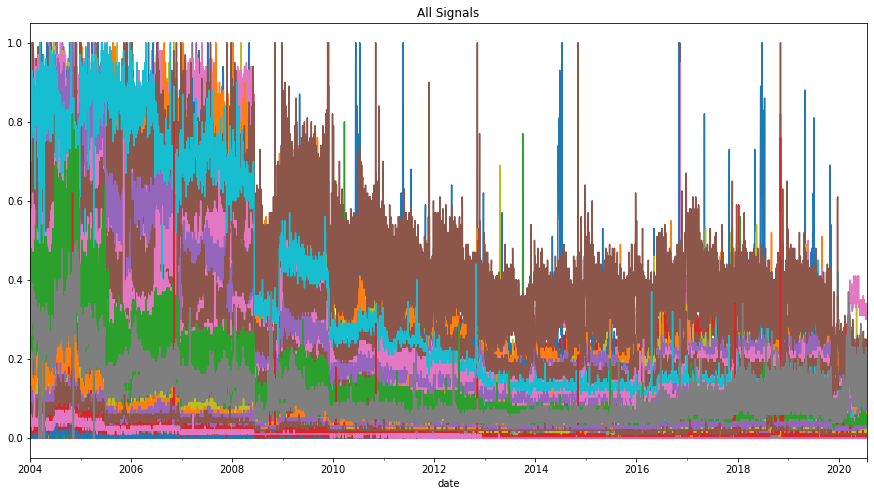

In [3]:
display(Markdown("### Word Signal"))
fig, ax = plt.subplots(figsize=(15,8))
trends_df.mean(1).rolling(7).mean().plot(ax=ax,legend=False);
ax.set_title("Rolling Mean");

fig, ax = plt.subplots(figsize=(15,8))
trends_df.plot(ax=ax,legend=False);
ax.set_title("All Signals");

## Market data returns

In [4]:
asset = "es1"
market_path = os.path.join('data','market',"{}.txt".format(asset))
df_market = pd.read_csv(market_path, sep='\t')
close_price_column = 'PX_LAST'
date_column='date'
df_market.loc[:, date_column] = pd.to_datetime(df_market[date_column])
df_market = df_market.set_index(date_column)
close = df_market[[close_price_column]].dropna()
close = close.pct_change().dropna()
return_column = "{}_returns".format(asset)
close.columns = [return_column]
close.head(5)

,es1_returns
date,
2000-01-04,-0.037501
2000-01-05,0.001241
2000-01-06,-0.006724
2000-01-07,0.039712
2000-01-10,0.010443


## Merging market data and trends data

In [5]:
merged_df = pd.merge_asof(trends_df, close, left_index=True, right_index=True)
merged_df = merged_df[[return_column] + word_features]
display(Markdown("### Merged data"))
display(HTML(merged_df.head(5).to_html()))
display(Markdown("#### data shape = {}".format(merged_df.shape)))

### Merged data

,es1_returns,BUY AND HOLD,DOW JONES,act,arts,banking,bonds,bubble,buy,cancer,car,carolina,case,cash,chance,college,color,committee,conflict,consume,consumption,conty,council,court,crash,credit,crisis,culture,debt,default,democratic,derivatives,district,dividend,dow jones,earnings,earths,economics,economy,elected,election,elections,energy,environment,fed,federal,finance,financial,fine,fond,food,forex,freedom,fun,gain,gains,garden,georgia,gold,government,governor,greed,growth,happy,headlines,health,hedge,holiday,home,house,housing,illinois,inflation,invest,investment,judge,justice,kentucky,kitchen,labor,law,legal,leverage,lifestyle,loss,market,markets,marriage,massachusetts,members,metals,minister,ministry,missouri,money,movement,movie,nasdaq,notability,nyse,office,ohio,oil,opportunity,ore,party,pennsylvania,police,political,politics,portfolio,present,president,profit,rare,religion,representatives,republican,restaurant,return,returns,revenue,rich,rights,ring,risk,seats,secretary,security,sell,selling,senate,served,short,society,stats,stock,stocks,success,tennessee,texas,tourism,trader,train,transaction,travel,unemployment,union,vermount,virginia,voter,votes,war,washington,water,william,winsconsin,world,york
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-01,0.002478,0.00,0.01,0.14,0.25,0.04,0.09,0.05,0.86,0.18,0.77,0.55,0.31,0.10,0.03,0.63,0.27,0.04,0.03,0.00,0.02,0.0,0.09,0.20,0.11,0.52,0.03,0.06,0.05,0.05,0.05,0.01,0.22,0.01,0.01,0.01,0.01,0.07,0.04,0.00,0.05,0.01,0.13,0.04,0.04,0.33,0.06,0.16,0.13,0.00,0.70,0.01,0.11,0.22,0.06,0.00,0.32,0.43,0.27,0.17,0.02,0.00,0.08,0.25,0.00,0.47,0.01,0.34,0.98,0.85,0.12,0.37,0.01,0.01,0.07,0.04,0.06,0.16,0.27,0.06,0.35,0.14,0.00,0.03,0.11,0.26,0.03,0.09,0.27,0.07,0.01,0.00,0.03,0.26,0.29,0.02,1.00,0.01,0.0,0.01,0.54,0.58,0.28,0.02,0.01,0.35,0.28,0.26,0.06,0.03,0.06,0.03,0.08,0.03,0.03,0.07,0.02,0.04,0.57,0.30,0.04,0.03,0.07,0.07,0.37,0.05,0.06,0.03,0.31,0.07,0.05,0.01,0.01,0.18,0.31,0.08,0.30,0.08,0.03,0.20,0.66,0.11,0.16,0.23,0.01,0.63,0.07,0.44,0.00,0.53,0.01,0.01,0.36,0.60,0.53,0.28,0.00,0.80,0.80
2004-01-02,-0.001348,0.00,0.02,0.17,0.25,0.03,0.05,0.03,0.76,0.19,0.77,0.49,0.26,0.09,0.02,0.81,0.25,0.03,0.04,0.00,0.02,0.0,0.11,0.33,0.11,0.66,0.03,0.08,0.05,0.06,0.05,0.01,0.32,0.01,0.03,0.01,0.01,0.04,0.03,0.00,0.03,0.02,0.17,0.04,0.04,0.47,0.11,0.31,0.11,0.01,0.52,0.01,0.05,0.15,0.04,0.02,0.29,0.48,0.29,0.26,0.03,0.01,0.07,0.18,0.01,0.71,0.02,0.28,0.99,0.95,0.14,0.53,0.02,0.01,0.10,0.03,0.06,0.15,0.21,0.09,0.52,0.14,0.01,0.02,0.12,0.27,0.03,0.14,0.27,0.06,0.02,0.02,0.03,0.24,0.31,0.04,0.95,0.03,0.0,0.02,0.69,0.63,0.26,0.02,0.01,0.33,0.32,0.30,0.10,0.03,0.02,0.03,0.11,0.03,0.05,0.05,0.01,0.03,0.44,0.25,0.02,0.08,0.08,0.10,0.30,0.06,0.06,0.10,0.43,0.09,0.05,0.03,0.01,0.14,0.33,0.04,0.35,0.10,0.04,0.18,0.77,0.10,0.11,0.21,0.01,0.59,0.09,0.54,0.00,0.61,0.02,0.01,0.41,0.80,0.55,0.32,0.01,0.94,0.91
2004-01-03,-0.001348,0.00,0.01,0.16,0.22,0.05,0.05,0.06,0.89,0.21,0.89,0.40,0.27,0.09,0.03,0.70,0.35,0.03,0.03,0.00,0.02,0.0,0.09,0.23,0.13,0.60,0.05,0.06,0.02,0.06,0.05,0.01,0.26,0.02,0.02,0.01,0.00,0.03,0.05,0.01,0.03,0.01,0.12,0.04,0.03,0.34,0.07,0.14,0.14,0.01,0.51,0.01,0.09,0.17,0.08,0.01,0.29,0.41,0.27,0.19,0.02,0.00,0.06,0.13,0.01,0.53,0.01,0.26,0.93,0.95,0.09,0.44,0.01,0.01,0.07,0.03,0.07,0.15,0.26,0.06,0.43,0.13,0.00,0.01,0.13,0.32,0.03,0.11,0.27,0.08,0.01,0.02,0.05,0.23,0.28,0.06,0.97,0.02,0.0,0.01,0.62,0.65,0.28,0.02,0.01,0.36,0.27,0.26,0.07,0.02,0.02,0.01,0.10,0.03,0.04,0.08,0.02,0.04,0.50,0.26,0.02,0.07,0.09,0.08,0.36,0.05,0.05,0.05,0.28,0.10,0.05,0.02,0.01,0.19,0.30,0.06,0.27,0.08,0.02,0.17,0.67,0.09,0.10,0.26,0.02,0.54,0.06,0.43,0.00,0.55,0.01,0.01,0.51,0.72,0.47,0.29,0.00,0.81,0.75
2004-01-04,-0.001348,0.01,0.01,0.18,0.26,0.05,0.06,0.06,0.81,0.17,0.84,0.51,0.26,0.10,0.03,0.68,0.27,0.03,0.04,0.01,0.03,0.0,0.10,0.27,0.10,0.53,0.03,0.07,0.05,0.07,0.08,0.02,0.31,0.02,

#### data shape = (6051, 159)

## Defining IS and OOS

In [6]:
# TODO